# Why is it okay/not okay to use the nonpar test statistic on estimated latent positions (with finite samples) without worrying about orthogonal transformations?

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from graspy.plot import heatmap, pairplot
from graspy.simulations import p_from_latent, sample_edges, rdpg
from graspy.embed import AdjacencySpectralEmbed

%matplotlib inline

def gaussian_covariance(X, Y, bandwidth):
    diffs = np.expand_dims(X, 1) - np.expand_dims(Y, 0)
    if bandwidth is None:
        bandwidth = 0.5
    return np.exp(-0.5 * np.sum(diffs ** 2, axis=2) / bandwidth ** 2)


def mmd_kernel(X, Y, bandwidth=1):
    N, _ = X.shape
    M, _ = Y.shape
    x_stat = np.sum(gaussian_covariance(X, X, bandwidth) - np.eye(N)) / (N * (N - 1))
    y_stat = np.sum(gaussian_covariance(Y, Y, bandwidth) - np.eye(M)) / (M * (M - 1))
    xy_stat = np.sum(gaussian_covariance(X, Y, bandwidth)) / (N * M)
    return x_stat - 2 * xy_stat + y_stat


# params
plt.style.use("seaborn-white")
sns.set_context("talk", font_scale=1.5)
sns.set_palette("Set1")
n = 200
n_per_block = n // 2

point1 = np.array([0.15, 0.6])
point2 = np.array([0.6, 0.15])
point3 = np.array([0.5, 0.62])

rot_mat = np.array([[-1, 0], [0, -1]])

Create 3 sets of latent positions.

$$X_1, X_2, X_3 \in \mathbb{R}^{n \times 2}$$
$$X_1 = X_2$$ 
$$X_1 \neq X_3$$

Plot $X_1$, $X_2$, $X_3$ on the same scatterplot. 

Compute nonpar kernel $MMD(., .)$ between $X_1$ and $X_2$, and between $X_1$ and $X_3$

X1 vs X2
-0.000921173454280888

X1 vs X3
0.029065474005286918



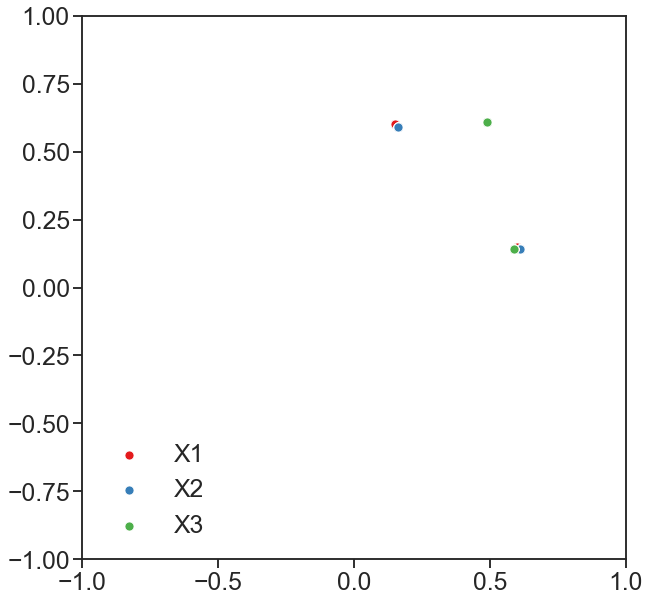

In [2]:
# create some latent positions
latent1 = np.tile(point1, (n_per_block, 1))
latent1 = np.concatenate((latent1, np.tile(point2, (n_per_block, 1))))

latent2 = latent1.copy()
# latent2 = latent2 @ rot_mat

latent3 = np.tile(point2, (n_per_block, 1))
latent3 = np.concatenate((latent3, np.tile(point3, (n_per_block, 1))))

# plot the true latent positions
plt.figure(figsize=(10, 10))
sns.scatterplot(x=latent1[:, 0], y=latent1[:, 1], label="X1")
# some manual jitter just so we can see
sns.scatterplot(x=latent2[:, 0]+0.01, y=latent2[:, 1]-0.01, label="X2") 
sns.scatterplot(x=latent3[:, 0]-0.01, y=latent3[:, 1]-0.01, label="X3")
plt.legend(loc='lower left')
plt.axis("square")
plt.xlim([-1, 1])
plt.ylim([-1, 1])

# compute nonpar test statistics between true latent positions
print("X1 vs X2")
print(mmd_kernel(latent1, latent2))
print()
print("X1 vs X3")
print(mmd_kernel(latent1, latent3))
print()

Sample 1 graph from each set of latent positions.

Plot the adjacency matrices.

Embed each graph with ASE (separately).

Plot the estimated latent positions ($\hat{X_.}$)

(-1, 1)

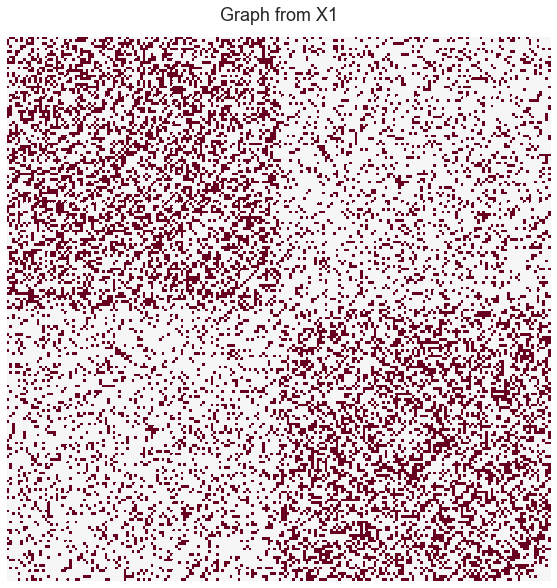

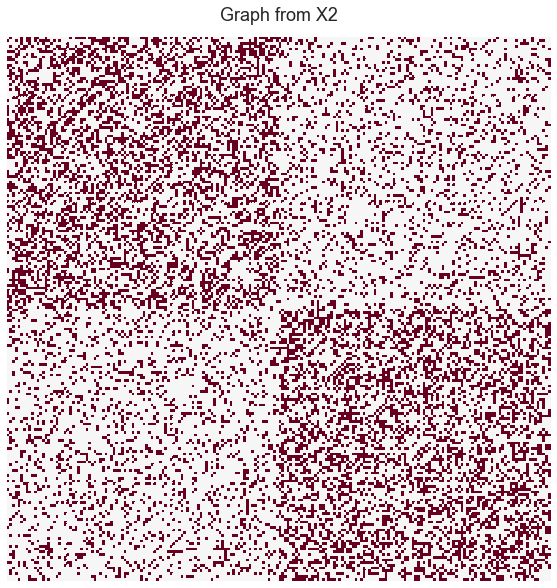

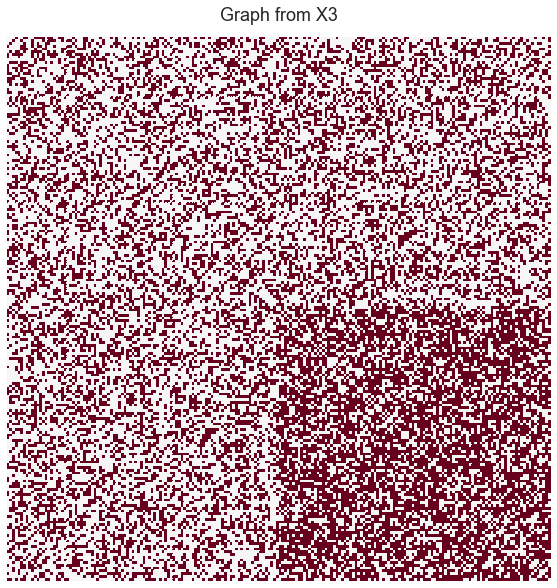

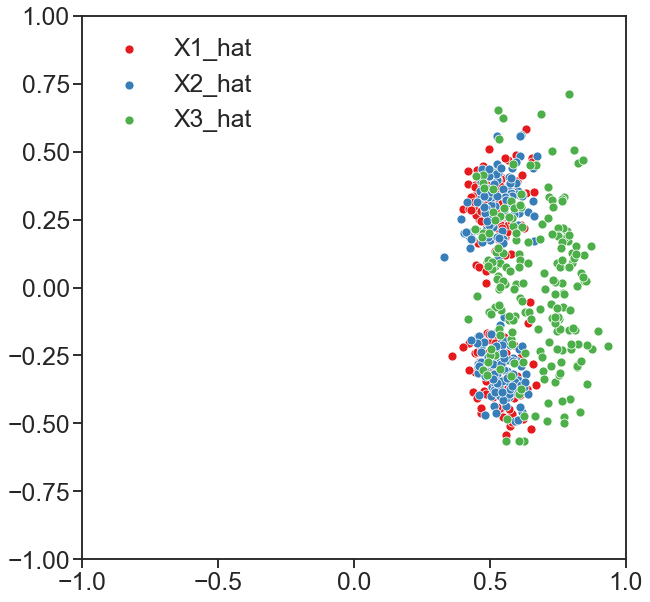

In [3]:
# sample graphs from them
graph1 = rdpg(latent1, rescale=False, loops=False)
graph2 = rdpg(latent2, rescale=False, loops=False)
graph3 = rdpg(latent3, rescale=False, loops=False)

# plot those graphs
heatmap(graph1, cbar=False, title="Graph from X1")
heatmap(graph2, cbar=False, title="Graph from X2")
heatmap(graph3, cbar=False, title="Graph from X3")

# embed the sampled graphs
ase = AdjacencySpectralEmbed(n_components=2)
latent1_hat = ase.fit_transform(graph1)
latent2_hat = ase.fit_transform(graph2)
latent3_hat = ase.fit_transform(graph3)

# plot the raw result of the embeddings
plt.figure(figsize=(10, 10))
sns.scatterplot(x=latent1_hat[:, 0], y=latent1_hat[:, 1], label="X1_hat")
sns.scatterplot(x=latent2_hat[:, 0], y=latent2_hat[:, 1], label="X2_hat")
sns.scatterplot(x=latent3_hat[:, 0], y=latent3_hat[:, 1], label="X3_hat")
plt.axis("square")
plt.xlim([-1, 1])
plt.ylim([-1, 1])

Rotate one of the sets of estimated latent positions ($\hat{X_2}$) such that it is still equal up to orthogonal tranformation.

$$\hat{X_2^{r}} = \hat{X_2} R$$

$$RR^T=R^TR = I$$

Plot the new estimated latent positions. 

Compute the nonpar test statistic between estimated latent positions, including the new one with the rotation.

X1_hat vs X2_hat
-0.0009692408001590325

X1_hat vs X3_hat
0.017139391134891935

X1_hat vs X2_hat (rotated)
0.7649461250554527


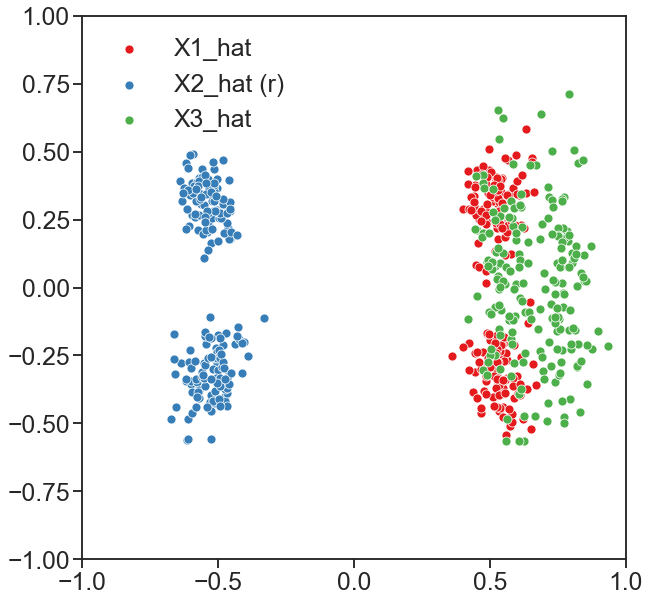

In [4]:
# rotate the estimated latent position of X2 and plot
latent2_hat_rot = latent2_hat @ rot_mat
plt.figure(figsize=(10, 10))
sns.scatterplot(x=latent1_hat[:, 0], y=latent1_hat[:, 1], label="X1_hat")
sns.scatterplot(x=latent2_hat_rot[:, 0], y=latent2_hat_rot[:, 1], label="X2_hat (r)")
sns.scatterplot(x=latent3_hat[:, 0], y=latent3_hat[:, 1], label="X3_hat")
plt.legend()
plt.axis("square")
plt.xlim([-1, 1])
plt.ylim([-1, 1])

# compute nonpar test statistics between estimated latent positions
print("X1_hat vs X2_hat")
print(mmd_kernel(latent1_hat, latent2_hat))
print()
print("X1_hat vs X3_hat")
print(mmd_kernel(latent1_hat, latent3_hat))
print()
print("X1_hat vs X2_hat (rotated)")
print(mmd_kernel(latent1_hat, latent2_hat_rot))